<a href="https://colab.research.google.com/github/sush2004/Python/blob/main/ref_CA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Display the total number of rows and column.***

Total number of rows: 38556
Total Number of columns: 11

***Display non-null & null value count by column.***

              Not_Null_Count  Null_Count
Date                   38556           0
Station Area           38556           0
Description            38556           0
TOC                    38556           0
ORD                    38556           0
MOB                    37311        1245
IA                     30962        7594
LS                     38556           0
AH                       153       38403
MAV                    38530          26
CD                     38530          26

***Display null value count for all column.***

Total number of null value for all the columns: 47294

***Display total number of call outs by Station Area.***

      Station Area  Total Calls
0       Balbriggan          688
1   Blanchardstown         2089
2    Dolphins Barn         4018
3       Donnybrook         1787
4    Dun Laoghaire     

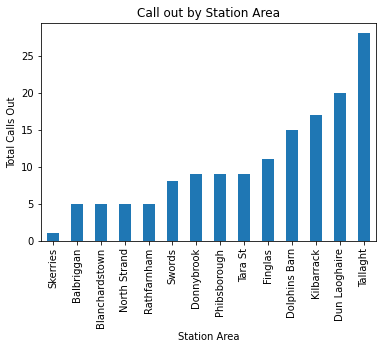

In [ ]:
#Author:Rajesh Kumar
#Description: ETL 
#Note: upload the 'FireBrigadeAndAmbulanceCallOuts.csv' file before running the program using collab.

#ChangeLog:
#17-01-2021 RK: Initial Version 
#18-01-2021 RK: Added function
#21-01-2021 RK: Added mapplot to preview tota call out after ETL transformation
#21-01-2021 RK: Added library warnings to ignore user warning received after data load to sqlite3.

import pandas as pd
import datetime as date
import sqlite3
import matplotlib.pyplot as plt                                                 
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)                    #ignore if any user warning

df=pd.read_csv('FireBrigadeAndAmbulanceCallOuts.csv')                           #read the csv file

#function to identify the number of row and column
def record_count():
  print('***Display the total number of rows and column.***\n')
  #computing number of rows
  rows = len(df.axes[0]) 
  print('Total number of rows: {}'.format(rows))
  # computing number of columns 
  cols = len(df.axes[1])
  print('Total Number of columns: {}'.format(cols))

#function to calculate the not null and null count by column 
def data_information():
  print('\n***Display non-null & null value count by column.***\n')
  #count not null /non-NA in each column
  not_null=df.count()
  #count null in each column
  null_col= df.isnull().sum()                                       
  df1=pd.DataFrame([not_null,null_col])                                         #assigning both data to one data frame
  df1=df1.transpose()                                                           #transpose to receive the data in column
  df1.columns=['Not_Null_Count','Null_Count']                                   #name the populated column
  return df1                                                                    #return the value 

#Function to calculate total null value for all the column
def null_for_col():
  print('\n***Display null value count for all column.***\n')
  null_col= df.isnull().sum()                                                   #computing null value by column
  null_col=null_col.sum()                                                       #sum the value to calculate null for all column           
  print('Total number of null value for all the columns: {}'.format(null_col))

#function to calculate total call out by Station area
def calls_by_station():
  print('\n***Display total number of call outs by Station Area.***\n')
  station_by=df.groupby('Station Area').count()['TOC']                          #total call out by station area 
  calls_out=station_by.reset_index(name='Total Calls')                          #named as Total calls using reset_index 
  return calls_out

#function to calculate total call out by date and Station area
def calls_by_date_station():
  print('\n***Display total number of call outs by Date and Station Area.***\n')
  tot_calls=df.groupby(['Date','Station Area']).count()['TOC']                  #total call out by Date and Station Area
  tot_calls=tot_calls.reset_index(name='Total Calls')                           #named as Total calls using reset_index
  return tot_calls

#function to filtered data information
def description():
  print('\n***Display total number of call outs by Station Area and Date where the description is either Fire Car or Fire Alarm.***\n')
  df_filter=df[df['Description'].isin(['Fire ALARM','Fire CAR'])]               #filter datafram where description in Fire Alarm or Fier CAR
  result_df=df_filter.groupby(['Station Area','Date']).count()['TOC']           #group by based on Station Area and date for total Call
  result_df=result_df.reset_index(name='Total Calls')
  return result_df

#Function for ETL Operation
def data_transformation():
  print('\n***Total not null Records count before transformation by column.***\n')
  print(df.count())
  print('\nTransformation Started..\n')
  data=df.replace(',', '')                                                      #replace , with empty string
  print('Replaced all , with empty string.')
  data=data.replace('-','')                                                     #replace - with empty string
  print('Replaced all - with empty string.')
  data=data.dropna(subset=['AH','MAV','CD'])                                    #drop row if any column has null value
  print('Dropped rows for the columns (AH, MAV, CD) where at least one row value is NULL.')
  emptyAH = data[ data['AH'] == '' ].index                                       #check if the column AH has empty string                       
  data=data.drop(emptyAH)                                                       #drop the empty value records from data frame
  print('Dropped row for empty string from AH.')
  emptyMAV = data[ data['MAV'] == '' ].index                                    #check if the column MAV has empty string
  data=data.drop(emptyMAV)                                                      #drop the empty value records from data frame
  print('Dropped row for empty string from MAV.')
  emptyCD = data[ data['CD'] == '' ].index                                      #check if the column CD has empty string
  data=data.drop(emptyCD)                                                       #drop the empty value records from data frame
  print('Dropped row for empty string from CD.')
  data=data.drop_duplicates(keep="first")                                       #drop the duplicate and keep only first records.
  print('Dropped duplicate rows except for the first occurrence.')
  print('\n***Final not null Record count after transformation by column***\n')
  print(data.count())
  toc=pd.to_datetime(data['TOC'])                                               #convert column TOC data to datetime
  ord=pd.to_datetime(data['ORD'])                                               #convert column ORD data to datetime
  diff=ord-toc
  diff=min(diff)                                                                #calculate the diff minimum difference 
  print('\nThe minimum time difference between TOC and ORD : {}'.format(diff))
  return data

#function to create the database and table
def create_db():
  print('\n***Database setup***')
  db = sqlite3.connect("Staging.db")                                            #create and connect the database 
  print('Connection established!!!')
  db.execute("drop table if exists FireBrigadeAndAmbulanceCallOuts")
  try:
    #create the table
    db.execute("create table FireBrigadeAndAmbulanceCallOuts(Date DATE, [Station Area] text,Description text, TOC text, ORD text, MOB text,IA text,LS text, AH text, MAV text, CD text)")
    Print('Table FireBrigadeAndAmbulanceCallOuts Created.')
  except:
    print("Table Already exist !!")
    
#function to insert the data to database
def insert_db(data):
  create_db()
  db = sqlite3.connect('Staging.db')
  print('Target connection established!! & ready to insert.')
  #assign table name to a variable
  table= 'FireBrigadeAndAmbulanceCallOuts'
  data.to_sql(table, db, if_exists='replace',index=False)                       #insert the data to database and replace if exist
  db.commit()                                                                   #save the inserted records using commit
  #get the count from table
  record_count=pd.read_sql('select count(*) as cnt from FireBrigadeAndAmbulanceCallOuts ',db)
  #Print the total  inserted records.
  print('Record {} Inserted into table FireBrigadeAndAmbulanceCallOuts.\n'.format(record_count['cnt'][0]))

#function to visualize the data after ETL operation
def view_data():
  conn = sqlite3.connect('Staging.db')
  #select the data from table
  result = pd.read_sql('SELECT * FROM FireBrigadeAndAmbulanceCallOuts', conn)
  print('***Plot the call out based on station area after ETL operation***\n')
  plot_station_data= result.groupby('Station Area').count()['TOC']              #group by station area to get the total call out
  plot_station_data.sort_values().plot(kind='bar')                              #plot the bar chart based on the above data
  #create the title
  plt.title('Call out by Station Area')
  #create the yaxis label
  plt.ylabel('Total Calls Out')

if __name__ == "__main__":
  record_count()
  print(data_information())
  null_for_col()
  print(calls_by_station())
  print(calls_by_date_station())
  print(description())
  insert_db(data_transformation())
  view_data()

